In [1]:
import torch

def calculate_ece(confidences, accuracies, n_bins=10) -> float:
    """
    Calculate the expected calibration error (ECE) given a list of confidence scores (0-1) and accuracy scores (0 or 1).
    """
    confidences = torch.tensor(confidences)
    accuracies = torch.tensor(accuracies)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = torch.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece.item()

In [2]:
import numpy as np
import pandas as pd

model_name_lists = [
    "Llama-3.2-3B-Instruct-Turbo",
    "Meta-Llama-3.1-8B-Instruct-Turbo",
    "Meta-Llama-3.1-70B-Instruct-Turbo",
    "Meta-Llama-3.1-405B-Instruct-Turbo",
    "gpt-4.1-mini",
    "gpt-4.1-nano",
    ]
path_format = """../analysis/{model_name}_confidence_acc_success"""
for model_name in model_name_lists:
    file_path = path_format.format(model_name=model_name)
    df = pd.read_csv(file_path)
    # print number of failed samples
    print(f"Number of failed samples for {model_name}: crossfail-{len(df[(df['Linguistic Success'] == 0) | (df['Logit Success'] == 0) | (df['Numerical Success'] == 0)])}, linguistic-{len(df[df['Linguistic Success'] == 0])}, logit-{len(df[df['Logit Success'] == 0])}, numerical-{len(df[df['Numerical Success'] == 0])}")
    

Number of failed samples for Llama-3.2-3B-Instruct-Turbo: crossfail-80, linguistic-58, logit-61, numerical-79
Number of failed samples for Meta-Llama-3.1-8B-Instruct-Turbo: crossfail-467, linguistic-258, logit-310, numerical-411
Number of failed samples for Meta-Llama-3.1-70B-Instruct-Turbo: crossfail-112, linguistic-63, logit-67, numerical-111
Number of failed samples for Meta-Llama-3.1-405B-Instruct-Turbo: crossfail-77, linguistic-44, logit-47, numerical-75
Number of failed samples for gpt-4.1-mini: crossfail-250, linguistic-225, logit-79, numerical-122
Number of failed samples for gpt-4.1-nano: crossfail-324, linguistic-126, logit-268, numerical-302


In [25]:
from sklearn.metrics import roc_auc_score

result_df = pd.DataFrame(columns=["Model Name", 
                                    "Accuracy", 
                                    "Linguistic ECE", 
                                    "Linguistic ECE - no fail", 
                                    "Linguistic AUROC", 
                                    "Linguistic AUROC - no fail", 
                                    "Logit ECE", 
                                    "Logit ECE - no fail", 
                                    "Logit AUROC",
                                    "Logit AUROC - no fail",
                                    "Verbal Numerical ECE", 
                                    "Verbal Numerical ECE-no fail" 
                                    "Verbal Numerical AUROC",
                                    "Verbal Numerical AUROC - no fail",
                                    ])

for model_name in model_name_lists:
    file_path = path_format.format(model_name=model_name)
    df = pd.read_csv(file_path)
    df_remove_failed = df[(df['Linguistic Success'] == 1) & (df['Logit Success'] == 1) & (df['Numerical Success'] == 1)].reset_index(drop=True)
    # print number of failed samples
    row = {
        "Model Name": model_name,
        "Accuracy": df['Accuracy'].mean(),
        "Linguistic ECE": calculate_ece(df['Linguistic Confidence'], df['Accuracy']),
        "Linguistic ECE - no fail": calculate_ece(df_remove_failed['Linguistic Confidence'], df_remove_failed['Accuracy']),
        "Linguistic AUROC": roc_auc_score(df['Accuracy'], df['Linguistic Confidence']),
        "Linguistic AUROC - no fail": roc_auc_score(df_remove_failed['Accuracy'], df_remove_failed['Linguistic Confidence']),
        "Logit ECE": calculate_ece(df['Logit Perplexity Confidence'], df['Accuracy']),
        "Logit ECE - no fail": calculate_ece(df_remove_failed['Logit Perplexity Confidence'], df_remove_failed['Accuracy']),
        "Logit AUROC": roc_auc_score(df['Accuracy'], df['Logit Perplexity Confidence']),
        "Logit AUROC - no fail": roc_auc_score(df_remove_failed['Accuracy'], df_remove_failed['Logit Perplexity Confidence']),
        "Verbal Numerical ECE": calculate_ece(df['Verbal Numerical Confidence'], df['Accuracy']),
        "Verbal Numerical ECE - no fail": calculate_ece(df_remove_failed['Verbal Numerical Confidence'], df_remove_failed['Accuracy']),
        "Verbal Numerical AUROC": roc_auc_score(df['Accuracy'], df['Verbal Numerical Confidence']),
        "Verbal Numerical AUROC - no fail": roc_auc_score(df_remove_failed['Accuracy'], df_remove_failed['Verbal Numerical Confidence']),
    }
    result_df = pd.concat([result_df, pd.DataFrame([row])], ignore_index=True)
    
    
result_df

/tmp/ipykernel_3887273/3023614729.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame([row])], ignore_index=True)


,Model Name,Accuracy,Linguistic ECE,Linguistic ECE - no fail,Linguistic AUROC,Linguistic AUROC - no fail,Logit ECE,Logit ECE - no fail,Logit AUROC,Logit AUROC - no fail,Verbal Numerical ECE,Verbal Numerical ECE-no failVerbal Numerical AUROC,Verbal Numerical AUROC - no fail,Verbal Numerical ECE - no fail,Verbal Numerical AUROC
0,Llama-3.2-3B-Instruct-Turbo,0.328125,0.372913,0.373695,0.748654,0.747082,0.482615,0.479832,0.510358,0.514138,0.519181,NaN,0.562541,0.522575,0.566758
1,Meta-Llama-3.1-8B-Instruct-Turbo,0.428773,0.325344,0.330055,0.767863,0.757426,0.392074,0.373131,0.499079,0.527788,0.343861,NaN,0.605298,0.355856,0.628977
2,Meta-Llama-3.1-70B-Instruct-Turbo,0.602726,0.252090,0.252630,0.724216,0.719173,0.223860,0.217375,0.550059,0.560761,0.278689,NaN,0.640088,0.281309,0.648515
3,Meta-Llama-3.1-405B-Instruct-Turbo,0.715093,0.183189,0.182939,0.735220,0.730161,0.160445,0.155795,0.609367,0.612881,0.162890,NaN,0.715843,0.163939,0.722203
4,gpt-4.1-mini,0.748172,0.191272,0.185536,0.748584,0.747189,0.142990,0.134233,0.714983,0.721424,0.165542,NaN,0.769444,0.166508,0.779855
5,gpt-4.1-nano,0.612783,0.268987,0.256211,0.776739,0.781351,0.237148,0.221219,0.682438,0.691642,0.246865,NaN,0.717592,0.245138,0.728777


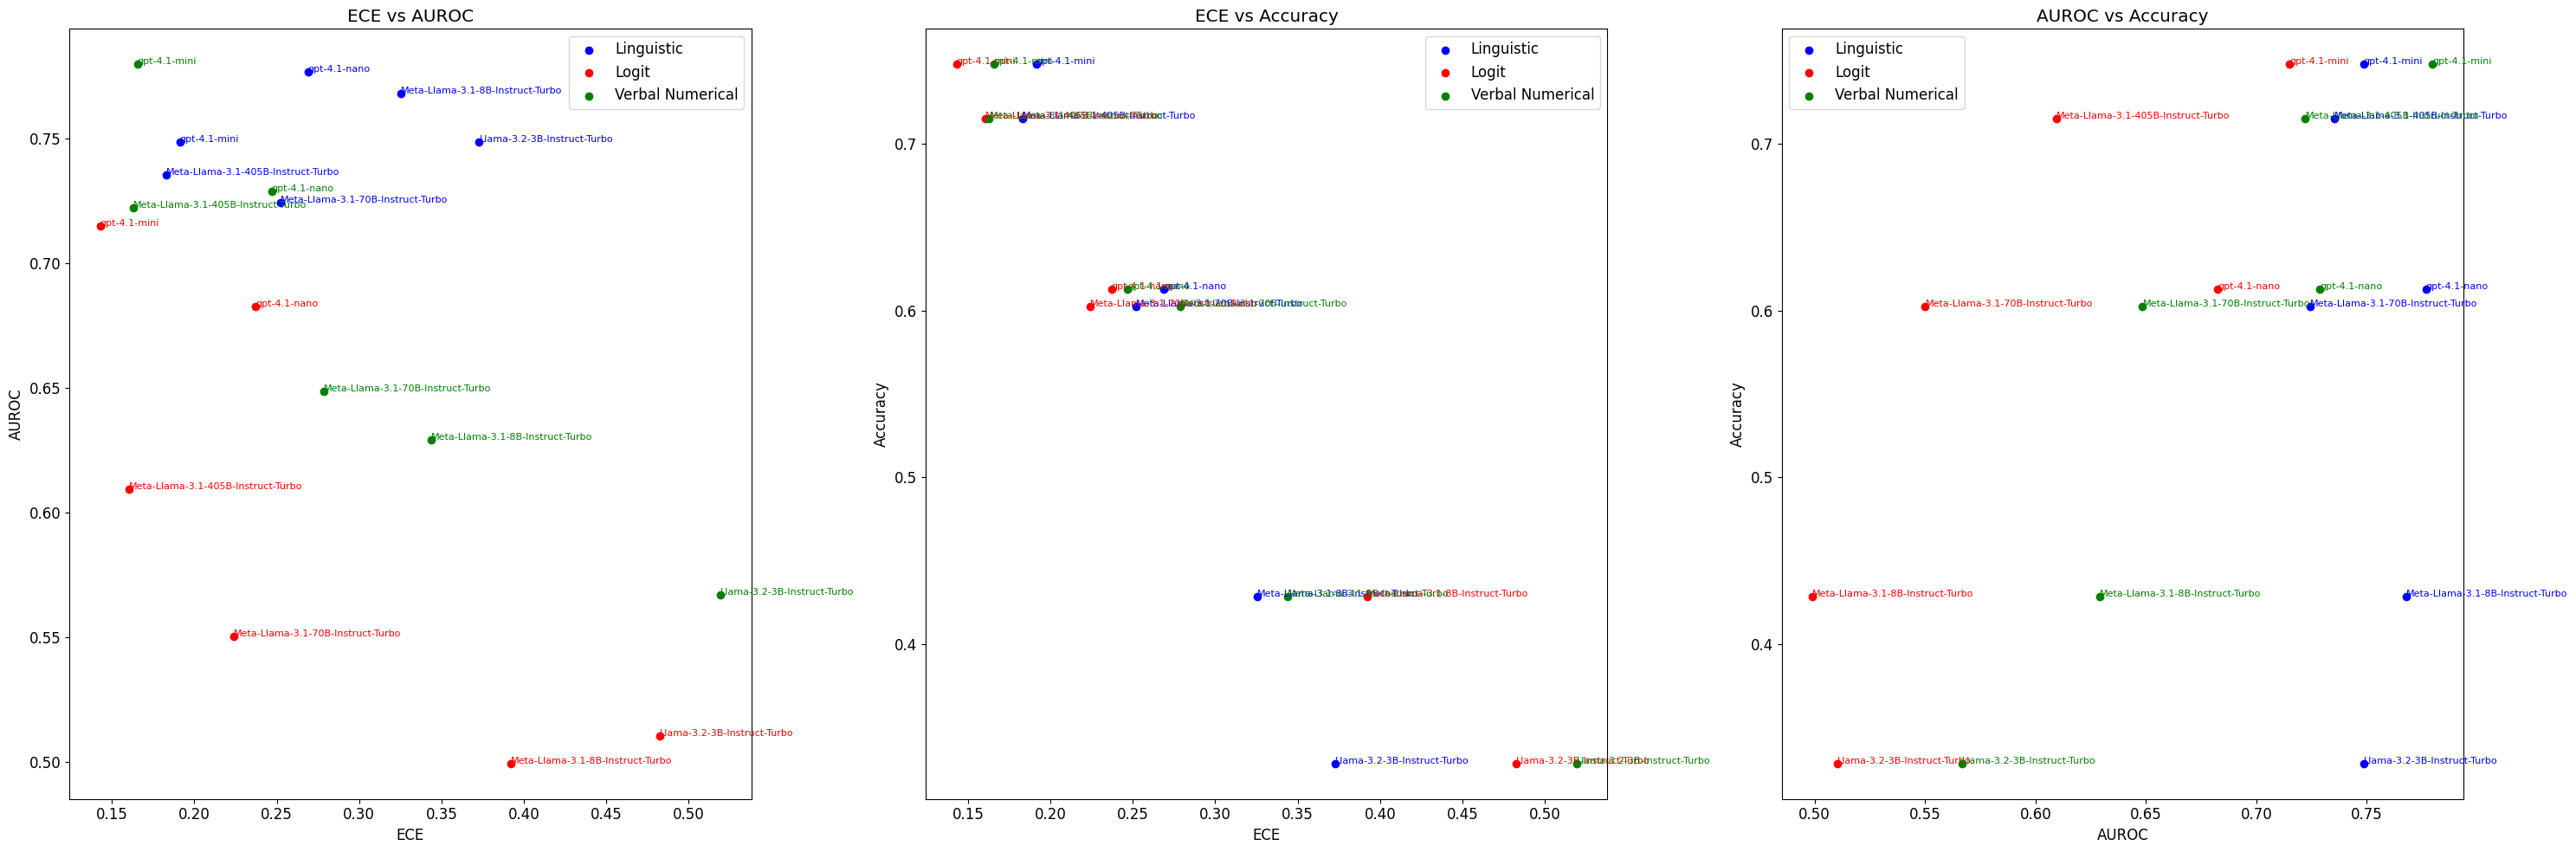

In [ ]:
# 绘制左中右三幅图
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# 左图：ECE vs AUROC
axes[0].scatter(result_df['Linguistic ECE'], result_df['Linguistic AUROC'], label='Linguistic', color='blue')
axes[0].scatter(result_df['Logit ECE'], result_df['Logit AUROC'], label='Logit', color='red')
axes[0].scatter(result_df['Verbal Numerical ECE'], result_df['Verbal Numerical AUROC'], label='Verbal Numerical', color='green')
for i, model_name in enumerate(result_df['Model Name']):
    axes[0].text(result_df['Linguistic ECE'][i], result_df['Linguistic AUROC'][i], model_name, fontsize=8, color='blue')
    axes[0].text(result_df['Logit ECE'][i], result_df['Logit AUROC'][i], model_name, fontsize=8, color='red')
    axes[0].text(result_df['Verbal Numerical ECE'][i], result_df['Verbal Numerical AUROC'][i], model_name, fontsize=8, color='green')
axes[0].set_xlabel('ECE')
axes[0].set_ylabel('AUROC')
axes[0].set_title('ECE vs AUROC')
axes[0].legend()

# 中图：ECE vs Accuracy
axes[1].scatter(result_df['Linguistic ECE'], result_df['Accuracy'], label='Linguistic', color='blue')
axes[1].scatter(result_df['Logit ECE'], result_df['Accuracy'], label='Logit', color='red')
axes[1].scatter(result_df['Verbal Numerical ECE'], result_df['Accuracy'], label='Verbal Numerical', color='green')
for i, model_name in enumerate(result_df['Model Name']):
    axes[1].text(result_df['Linguistic ECE'][i], result_df['Accuracy'][i], model_name, fontsize=8, color='blue')
    axes[1].text(result_df['Logit ECE'][i], result_df['Accuracy'][i], model_name, fontsize=8, color='red')
    axes[1].text(result_df['Verbal Numerical ECE'][i], result_df['Accuracy'][i], model_name, fontsize=8, color='green')
axes[1].set_xlabel('ECE')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('ECE vs Accuracy')
axes[1].legend()

# 右图：AUROC vs Accuracy
axes[2].scatter(result_df['Linguistic AUROC'], result_df['Accuracy'], label='Linguistic', color='blue')
axes[2].scatter(result_df['Logit AUROC'], result_df['Accuracy'], label='Logit', color='red')
axes[2].scatter(result_df['Verbal Numerical AUROC'], result_df['Accuracy'], label='Verbal Numerical', color='green')
for i, model_name in enumerate(result_df['Model Name']):
    axes[2].text(result_df['Linguistic AUROC'][i], result_df['Accuracy'][i], model_name, fontsize=8, color='blue')
    axes[2].text(result_df['Logit AUROC'][i], result_df['Accuracy'][i], model_name, fontsize=8, color='red')
    axes[2].text(result_df['Verbal Numerical AUROC'][i], result_df['Accuracy'][i], model_name, fontsize=8, color='green')
axes[2].set_xlabel('AUROC')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('AUROC vs Accuracy')
axes[2].legend()

plt.tight_layout()
plt.savefig("ece_auroc_accuracy.pdf", dpi=300)
plt.show()